In [1]:
# Install Graphviz
!apt install -y graphviz
!pip install graphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


**Import Libraries**

In [2]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve
)


In [3]:
# Load the dataset
df = pd.read_csv('/content/heart.csv')


**SPLIT DATA**

In [5]:
X = df.drop("target", axis=1)
y = df["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Train and visualize Decision Tree**

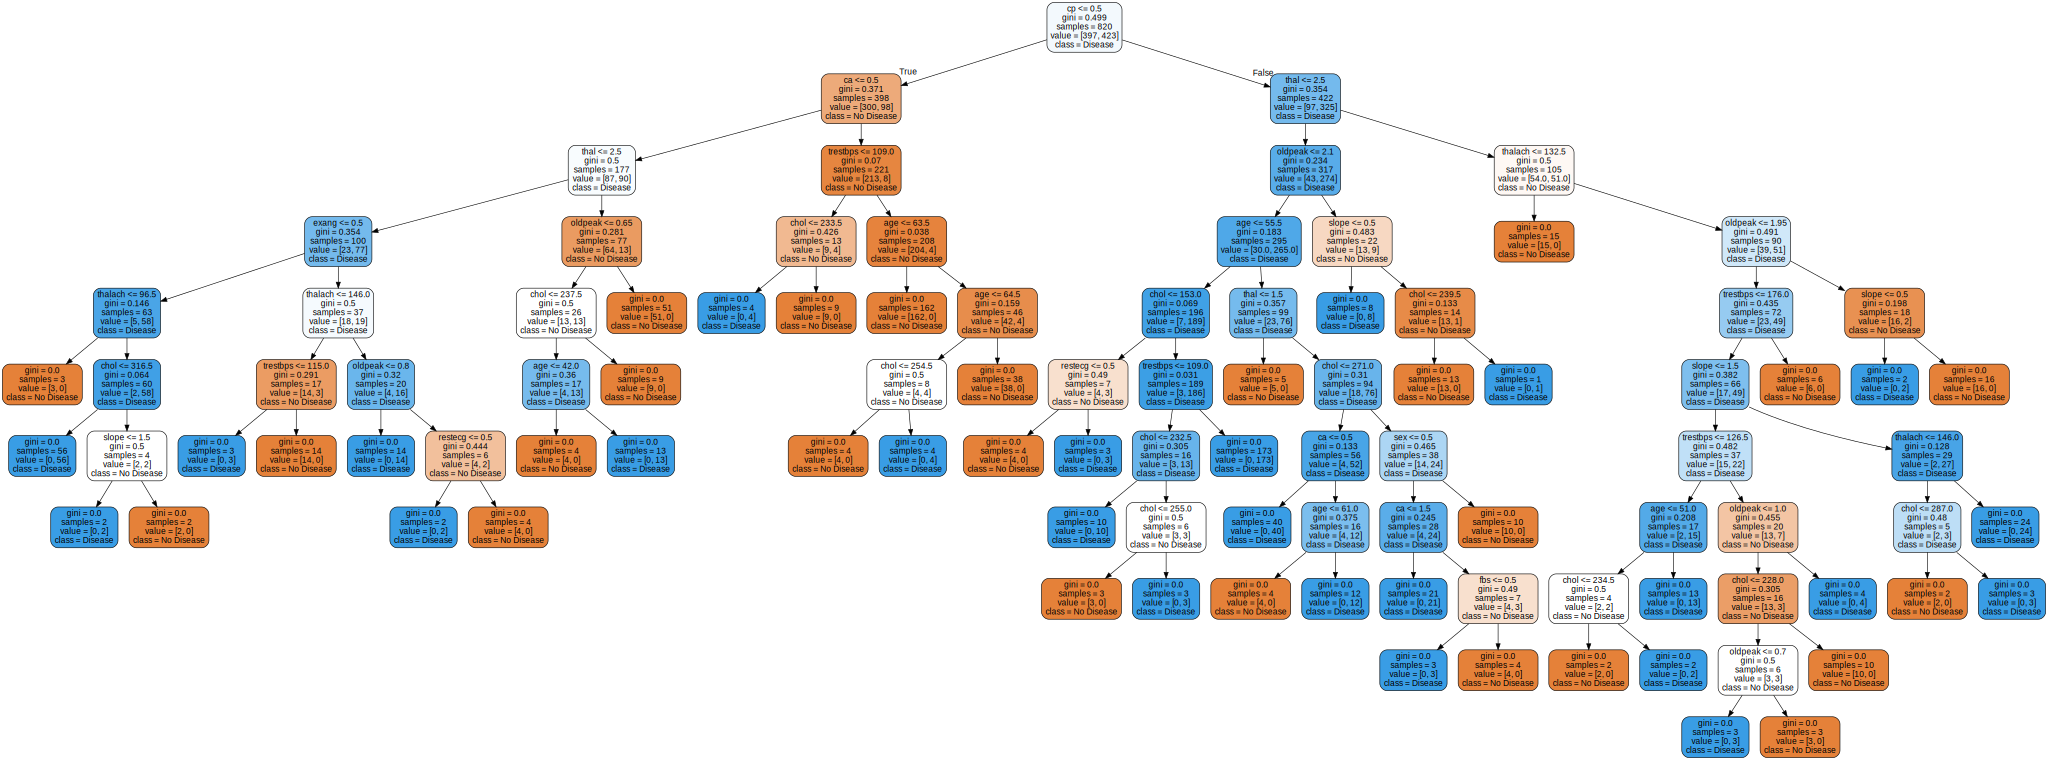

In [6]:
dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_train, y_train)

dot_data = export_graphviz(dtree, feature_names=X.columns, class_names=["No Disease", "Disease"],
                           filled=True, rounded=True, out_file=None)
graph = graphviz.Source(dot_data)
graph.render("decision_tree", format="png", cleanup=True)
graph

**Limit tree depth**

In [7]:
dtree_limited = DecisionTreeClassifier(max_depth=3, random_state=42)
dtree_limited.fit(X_train, y_train)
print("Decision Tree (max_depth=3):")
print("Train Accuracy:", dtree_limited.score(X_train, y_train))
print("Test Accuracy:", dtree_limited.score(X_test, y_test))

Decision Tree (max_depth=3):
Train Accuracy: 0.8512195121951219
Test Accuracy: 0.7804878048780488


**Train Random Forest**

In [8]:
rforest = RandomForestClassifier(random_state=42)
rforest.fit(X_train, y_train)
rf_preds = rforest.predict(X_test)
print("Random Forest - Test Accuracy:", accuracy_score(y_test, rf_preds))

Random Forest - Test Accuracy: 0.9853658536585366


**Feature Importances**

In [9]:
importances = rforest.feature_importances_
feature_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_df = feature_df.sort_values(by='Importance', ascending=False)

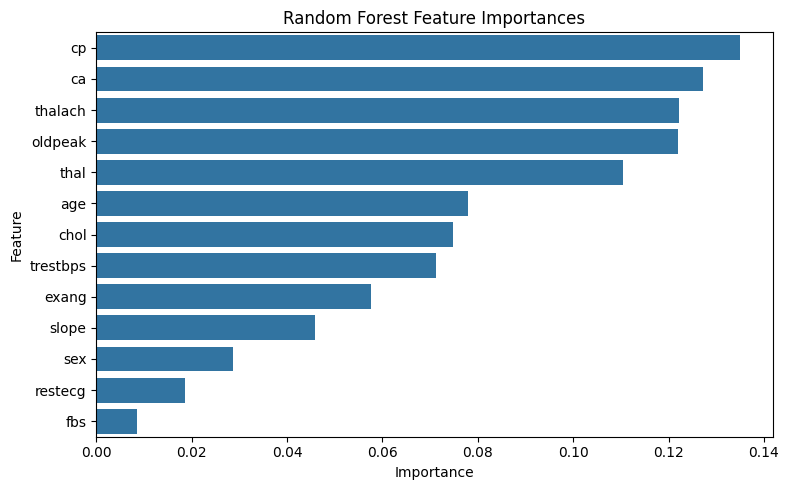

In [10]:
plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=feature_df)
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()


**Cross-validation**

In [11]:
cv_scores = cross_val_score(rforest, X, y, cv=5)
print(f"Cross-Validation Accuracy: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")

Cross-Validation Accuracy: 1.00 ± 0.01


**Hyperparameter Tuning for Decision Tree**

In [12]:
params = {
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10]
}
grid = GridSearchCV(DecisionTreeClassifier(random_state=42), params, cv=5)
grid.fit(X_train, y_train)

print("Best Parameters (Decision Tree):", grid.best_params_)
print("Best CV Score:", grid.best_score_)

Best Parameters (Decision Tree): {'max_depth': None, 'min_samples_split': 2}
Best CV Score: 0.975609756097561


**Confusion Matrix and Classification Report**


Classification Report (Random Forest):

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       102
           1       1.00      0.97      0.99       103

    accuracy                           0.99       205
   macro avg       0.99      0.99      0.99       205
weighted avg       0.99      0.99      0.99       205



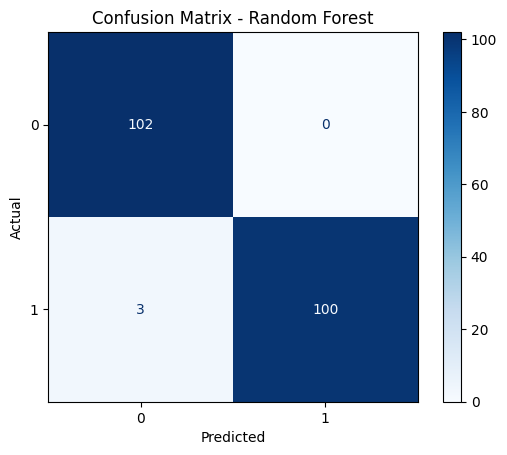

In [14]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

print("\nClassification Report (Random Forest):\n")
print(classification_report(y_test, rf_preds))

conf_mat = confusion_matrix(y_test, rf_preds)

# Use ConfusionMatrixDisplay to plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot(cmap='Blues')

plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

**ROC Curve and AUC Score**

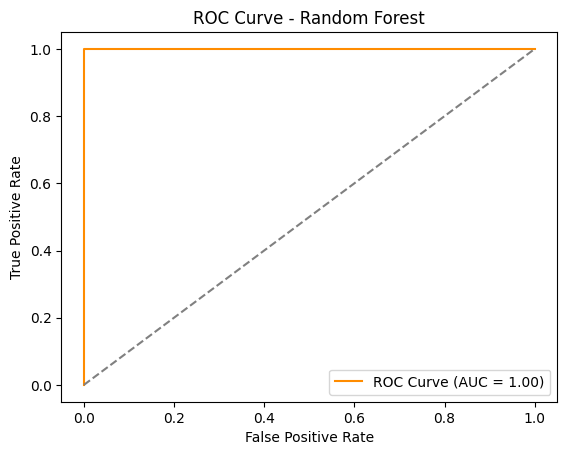

In [15]:
rf_probs = rforest.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, rf_probs)
roc_auc = roc_auc_score(y_test, rf_probs)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend(loc="lower right")
plt.show()

**Visualize a Single Tree from Random Forest**

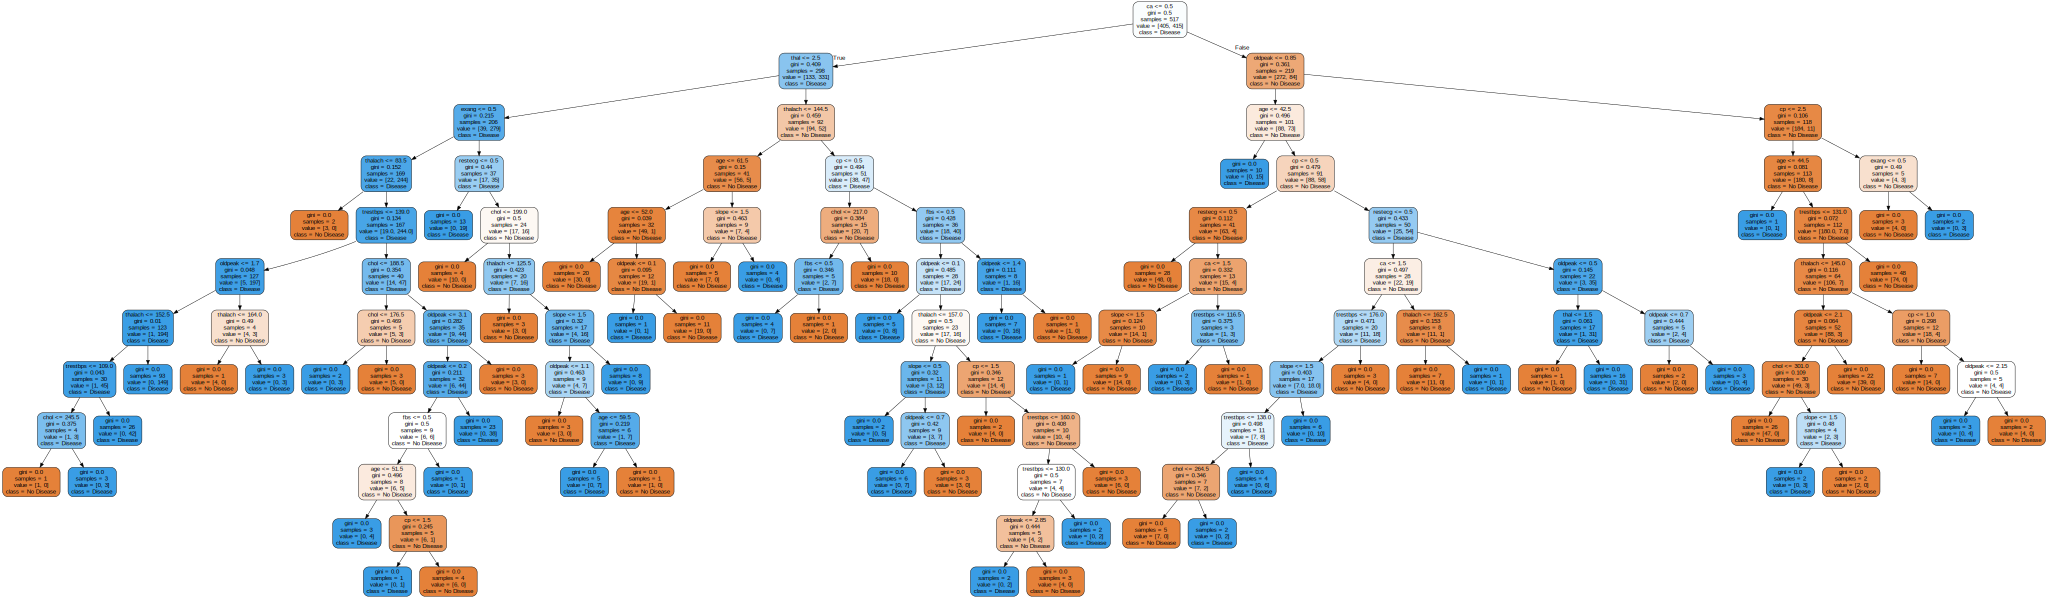

In [16]:
estimator = rforest.estimators_[0]
dot_data = export_graphviz(estimator, feature_names=X.columns, class_names=["No Disease", "Disease"],
                           filled=True, rounded=True, out_file=None)
graph_rf = graphviz.Source(dot_data)
graph_rf.render("random_forest_tree", format="png", cleanup=True)
graph_rf

**Out-of-Bag (OOB) Score**

In [17]:
# Random Forest with OOB score enabled
rforest_oob = RandomForestClassifier(oob_score=True, n_estimators=100, random_state=42)
rforest_oob.fit(X_train, y_train)
print("OOB Score (Random Forest):", rforest_oob.oob_score_)


OOB Score (Random Forest): 0.9939024390243902


**Plot Accuracy vs Number of Trees**

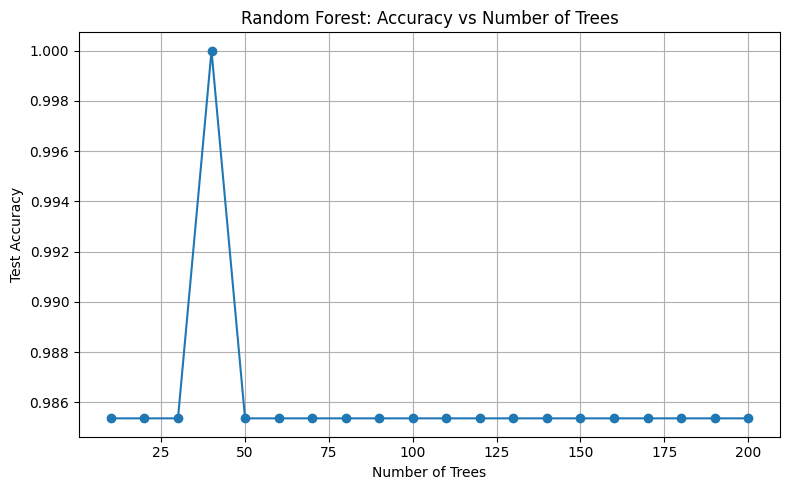

In [18]:
# Track accuracy as we increase number of trees
n_estimators_range = range(10, 201, 10)
scores = []

for n in n_estimators_range:
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    rf.fit(X_train, y_train)
    scores.append(rf.score(X_test, y_test))

plt.figure(figsize=(8, 5))
plt.plot(n_estimators_range, scores, marker='o')
plt.xlabel("Number of Trees")
plt.ylabel("Test Accuracy")
plt.title("Random Forest: Accuracy vs Number of Trees")
plt.grid(True)
plt.tight_layout()
plt.show()


**Partial Dependence Plot (Model Explainability)**

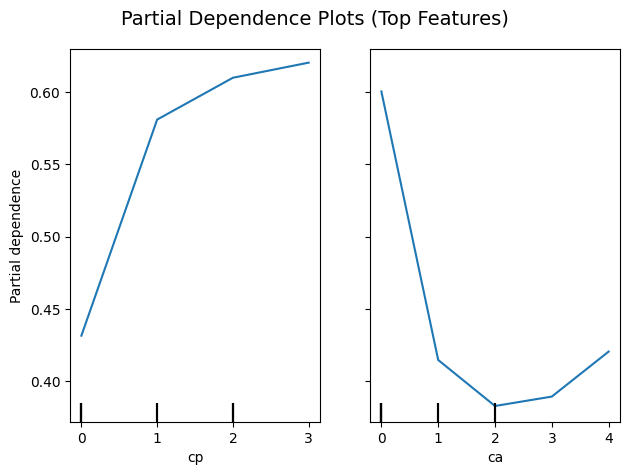

In [19]:
from sklearn.inspection import PartialDependenceDisplay

# Partial dependence for top 2 important features
top2_features = feature_df['Feature'].iloc[:2].tolist()

PartialDependenceDisplay.from_estimator(rforest, X, features=top2_features, kind="average")
plt.suptitle("Partial Dependence Plots (Top Features)", fontsize=14)
plt.tight_layout()
plt.show()


**Accuracy vs Tree Depth (Decision Tree)**

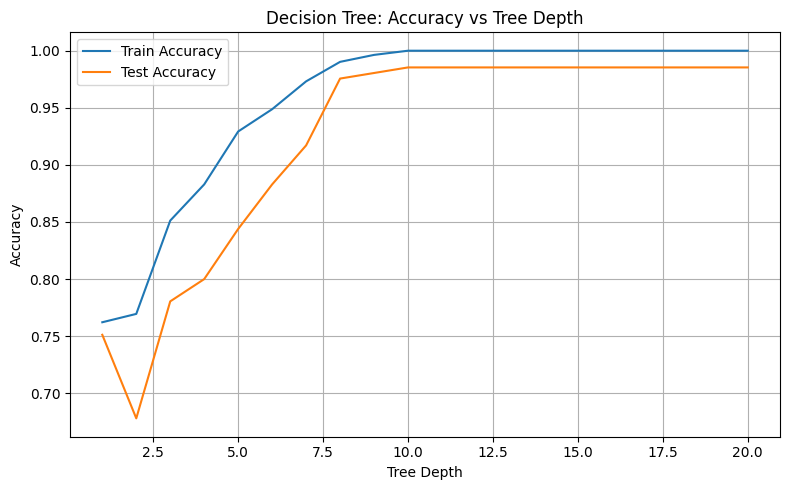

In [20]:
depths = range(1, 21)
train_scores = []
test_scores = []

for d in depths:
    model = DecisionTreeClassifier(max_depth=d, random_state=42)
    model.fit(X_train, y_train)
    train_scores.append(model.score(X_train, y_train))
    test_scores.append(model.score(X_test, y_test))

plt.figure(figsize=(8, 5))
plt.plot(depths, train_scores, label="Train Accuracy")
plt.plot(depths, test_scores, label="Test Accuracy")
plt.xlabel("Tree Depth")
plt.ylabel("Accuracy")
plt.title("Decision Tree: Accuracy vs Tree Depth")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Random Forest Stability Across Seeds**

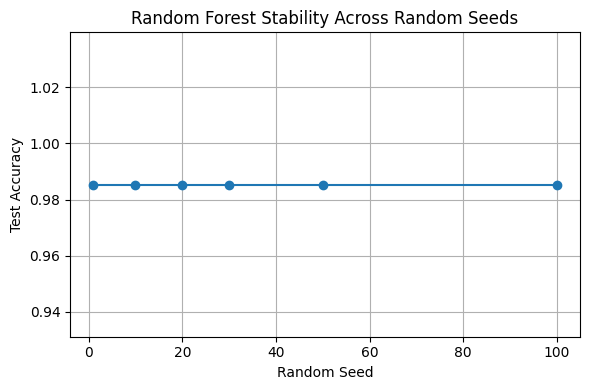

In [21]:
seeds = [1, 10, 20, 30, 50, 100]
scores = []

for seed in seeds:
    rf = RandomForestClassifier(random_state=seed)
    rf.fit(X_train, y_train)
    score = accuracy_score(y_test, rf.predict(X_test))
    scores.append(score)

plt.figure(figsize=(6, 4))
plt.plot(seeds, scores, marker='o')
plt.title("Random Forest Stability Across Random Seeds")
plt.xlabel("Random Seed")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()


**Gini vs Entropy (Decision Tree Comparison)**

In [22]:
for criterion in ['gini', 'entropy']:
    clf = DecisionTreeClassifier(criterion=criterion, max_depth=4, random_state=42)
    clf.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    print(f"Accuracy using {criterion.upper()}: {acc:.2f}")


Accuracy using GINI: 0.80
Accuracy using ENTROPY: 0.79


**Reduce Training Size and Compare**

In [23]:
small_X_train, _, small_y_train, _ = train_test_split(X_train, y_train, train_size=0.2, random_state=42)
rf_small = RandomForestClassifier(random_state=42)
rf_small.fit(small_X_train, small_y_train)
small_acc = accuracy_score(y_test, rf_small.predict(X_test))
print(f"Random Forest trained on 20% of data - Test Accuracy: {small_acc:.2f}")


Random Forest trained on 20% of data - Test Accuracy: 0.86


**Learning Curve**

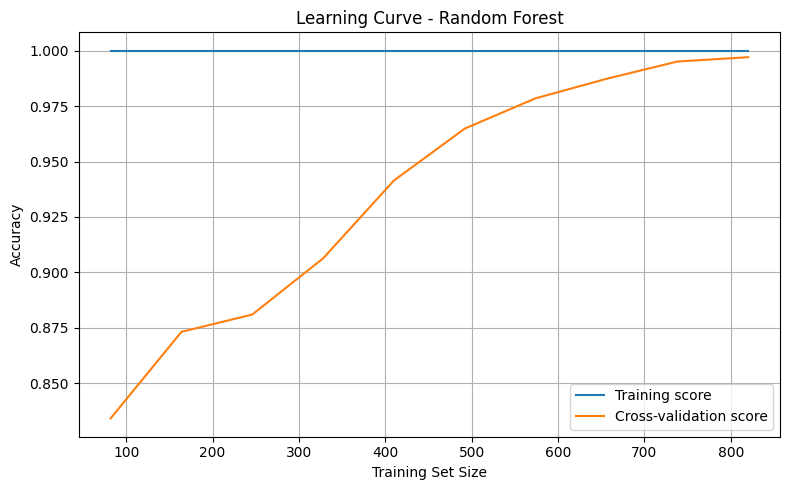

In [25]:
from sklearn.model_selection import learning_curve
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    RandomForestClassifier(random_state=42), X, y,
    train_sizes=np.linspace(0.1, 1.0, 10), cv=5
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, label="Training score")
plt.plot(train_sizes, test_mean, label="Cross-validation score")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve - Random Forest")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()